# Data analysis

This notebook is the second part of the Ebay sentiment analysis project. 
The downloaded reviews were analized and cleaned for modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
pd.set_option('display.max_rows', 500)

__Loading the datasets. There are two files with data, because Ebay reviews were downloaded in two steps.__
__Note: many reviews are duplicated, this issue is resolved later__

In [4]:
data = pd.read_csv('ebay_reviews.csv', index_col='Unnamed: 0')
data2 = pd.read_csv('ebay_reviews30122020.csv', index_col='Unnamed: 0')
data = pd.concat([data, data2])

In [5]:
data.head()

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


## Data cleaning transformers

In [6]:
class DuplicatesRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove duplicated rows.
    """
    def fit(self, X, y=None):
        self.duplicated_idx = X.duplicated()
        return self

    def transform(self, X):
        X2 = X.copy()
        X2 = X2[~self.duplicated_idx].dropna()
        return X2.set_index(np.arange(X2.shape[0]))

In [7]:
class ForeignReviewsRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove non-english reviews.
    If no word from the common-english-wordslist is found in a review/title the row is treated as nonenglish
    
    see_dismissed - if True non-english rows are displayed
    """
  
    def __init__(self, see_dismissed=False):
        words = stopwords.words('english')
        additional_words = ['good','beautiful', 'great','best','well','work','working','excellent','price','nice','handy','bad','terrible','worse','worst','broken','no','useless', 'ok','yes','fine','ok','awesome','awful', 'low', 'high', 'cool']
        words_to_remove={'i','me','a','d','o','y','s','t','don','ma'}
        words.extend(additional_words)
        self.words = list(set(words).difference(words_to_remove))
        self.see_dismissed = see_dismissed

    def fit(self, X, y=None, user_words=[]):
        self.words.extend(user_words)
        self.pattern = " | ".join(self.words) + "| ".join(self.words) + " |".join(self.words)
        X2 = X.copy()
        X_temp = pd.DataFrame()
        cols_to_join = []
        
        for col in X2.columns:
            if not X2.loc[:, col].dtypes == int:
                cols_to_join.append(col)
                
        X_temp['connected'] = X2[cols_to_join].astype(str).agg(' '.join, axis=1)
        self.idx = np.where(X_temp['connected'].str.contains(self.pattern, case=False, regex=True).values == True, True, False)
        return self

    def transform(self, X):
        X2 = X.copy()
        if self.see_dismissed == True:
            for row in X2['connected'][~self.idx]:
                print(row)
        return X2[self.idx]

In [8]:
class TextCleaning(BaseEstimator, TransformerMixin):
    """
    Transformer to remove punctation and multiple spaces from text and change uppercase letters to lowercase.
    """
    def __init__(self, pattern="[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]"):
        self.pattern = pattern
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X2.replace({"\s\s+":" "}, regex=False, inplace=True)
        
        for col in X2.columns:
            if X2.loc[:, col].dtypes == int: continue
            X2.loc[:, col] = X2.loc[:, col].str.replace(self.pattern, "", regex=True).str.lower()
        return X2

In [9]:
class StopWordsRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to remove popular english words with some default exceptions. User can add his own words to keep.
    """
    
    def __init__(self, words_to_keep=['few','not', 'off','all','any','not','no','very']):
        stop_words = set(stopwords.words('english'))    
        self.eng_words = stop_words.difference(set(words_to_keep))
         
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        
        for col in X2.columns:
            if X2.loc[:, col].dtypes == int: continue
            for en, review in enumerate(X2.loc[:, col].astype(str)):
                new = (" ").join(j for j in review.split(" ") if j.lower() not in self.eng_words)
                try:
                    X2.loc[:, col].iloc[en] = new
                except:
                    continue
        return X2

In [10]:
class Stemmer(BaseEstimator, TransformerMixin):
    """
    Transformer to stemm words.
    stem - if False the words are not stemmed (for experimental reasons)
    """
    
    def __init__(self, stem=True):
        self.stemmer = nltk.PorterStemmer()
        self.stem = stem
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.stem == False:
            return X
        else:
            X2 = X.copy()  
            for col in X2.columns:
                if X2.loc[:, col].dtypes == int: continue
                for en, review in enumerate(X2.loc[:, col].astype(str)):
                    new = (" ").join(self.stemmer.stem(j) for j in review.split(" "))
                    try:
                        X2[:, col].iloc[en] = new
                    except:
                        continue
            return X2

In [11]:
class Connector(BaseEstimator, TransformerMixin):
    """
    Transformer to connect columns in one column.
    """
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X3 = pd.DataFrame()
        cols_to_join = []
        for col in X2.columns:
            if X2.loc[:, col].dtypes == int:
                X3['rating'] = X2.loc[:, col]     
            else:
                cols_to_join.append(col)
                
        X3['review'] = X2[cols_to_join].astype(str).agg(' '.join, axis=1)
        return X3

In [12]:
class Rating(BaseEstimator, TransformerMixin):
    """
    Transformer to change reviews ratings numbers
    labels_to_del - a list of reviews rating to remove (the assumption is that only ratings with 3 starts will be removed)
    """
    def __init__(self, scale={1:1, 2:1, 3:0, 4:0, 5:0}, labels_to_del=[]):
        self.scale = scale
        self.labels_to_del = labels_to_del
    
    def fit(self, X, y=None):
        if self.labels_to_del != []:
            self.idx_to_del = X['rating'] == self.labels_to_del[0]
        return self

    def transform(self, X):    
        X2 = X.copy()
        if self.labels_to_del:
            X2 = X2[~self.idx_to_del]
        X2.replace(self.scale, inplace=True)
        return X2

## Data analysis
__Removing duplicated rows__

In [13]:
dr = DuplicatesRemover()
dr.fit(data)
data_temp = dr.transform(data)

__Ratings counts__

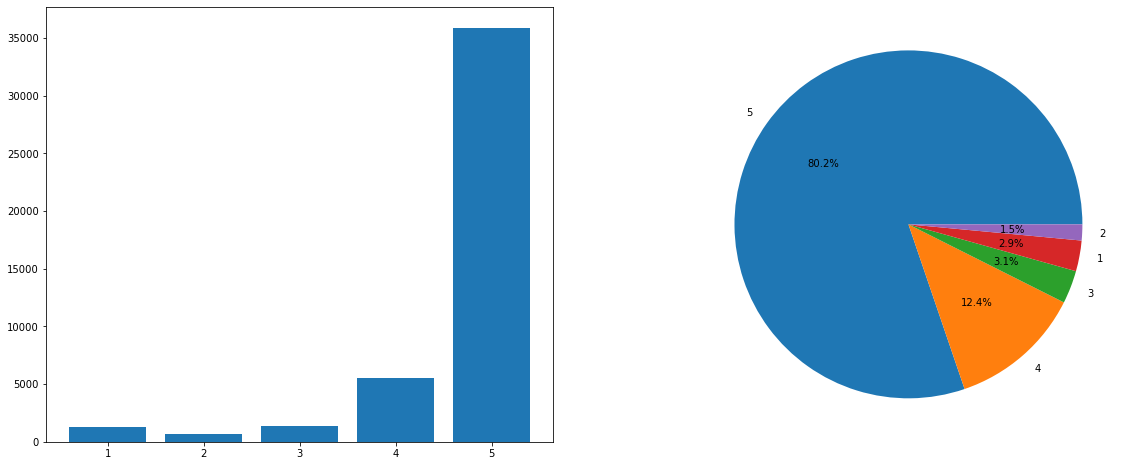

In [29]:
x = data_temp.rating.astype(int).value_counts().index
y = data_temp.rating.astype(int).value_counts().values

fig, ax = plt.subplots(ncols=2, figsize=(20,8))

ax[0].bar(x, y)
ax[1].pie(y, labels=x, autopct='%1.1f%%')
plt.show()

__Top 20 categories__

In [39]:
data_temp['category'].value_counts().head(20)

Cell Phones & Smartphones       9861
Digital Cameras                 4565
Video Games                     3588
Headphones                      3442
Cordless Drills                 1736
Video Game Consoles             1672
Monitors                        1563
Camcorders                      1514
Mice, Trackballs & Touchpads    1247
Keyboards & Keypads             1201
Smart Speakers                  1042
PC Laptops & Netbooks           1018
Reciprocating Saws               678
Apple Laptops                    583
Circular Saws                    573
Lenses                           573
Men's Shavers                    557
Media Streamers                  413
Internal Hard Disk Drives        400
Headsets                         336
Name: category, dtype: int64

__Some neutral reviews (3 stars out of 5)__

In [40]:
for comment in data_temp[data_temp['rating'] == 3]['review content'].sample(10):
    print()
    print(comment)


The external state is like new, but one of the speakers wheezes a little. Very upset

As an owner of 3 other Canon EOS DSLRs,  I was excited about adding this supposedly compact version containing all the latest Canon upgrades. Afterall, it was listed by all the camera mags as one of the top 5 DSLRs of the year. However, upon delivery and comparison to my Canon T3, T6, and 70D, this camera contained the goodies in a very cheap feeling, lightweight, plastic body. Granted, it is made for beginners but it still has the latest Digic processing system 7, their hottest CMOS dual pixel focusing feature which is great for well-focused videos and shooting pics off the LCD screen vs through the viewfinder., an articulating high pixed LCD, etc. However, in shooting with it, it didn't have that "solid" shutter click that all my older, less featured Canons have. In addition, it was TOO compact for my large hands, thus the toy-like feeling. I did a test comparison of a scene and shot it was all 3 D

__Reviews preprocessing__

In the following cell the reviews are cleaned (using the transformesrs). In order to get as much information as possible the title and the review content are connected.

In [41]:
#transformers for classic machine learning approach
cols = ['review title', 'review content', 'rating']

preprocessor = Pipeline([
    ('DuplicateRemover', DuplicatesRemover()),
    ('ForeignReviewsRemover',ForeignReviewsRemover()),
    ('TextCleaning',TextCleaning()),
    ('StopWordsRemover',StopWordsRemover()),
    ('Stemmer', Stemmer(stem=False)),
    ('Connector', Connector()),
    ('Rating', Rating(scale={1:-1, 2:-1, 3:0, 4:1, 5:1})),
    ('DuplicateRemover2', DuplicatesRemover())
])

In [42]:
preprocessor.fit(data[cols])
data_preprocessed = preprocessor.transform(data[cols])

/usr/lib/python3/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
data_preprocessed.head(10)

,rating,review
0,1,wireless gaming headset gaming headset ticks ...
1,0,good big head low budget easy setup rated 6 ho...
2,1,mezumiwireless gaming headset originally bough...
3,1,hw s2 great headset 2nd mezumi headset kills f...
4,1,best headphones ive purchased entire life prob...
5,1,great headset worth 50 headsert great value re...
6,1,works well aware dose not connect xbox wirele...
7,1,haven’t worked wifi yet glad still use tho ver...
8,1,all good all good product described
9,1,good price probably best low cost headset mar...


__Wordclouds of negative, neutral and positive reviews__

In [44]:
data_preprocessed.rating.value_counts()

 1    42282
-1     2025
 0     1442
Name: rating, dtype: int64

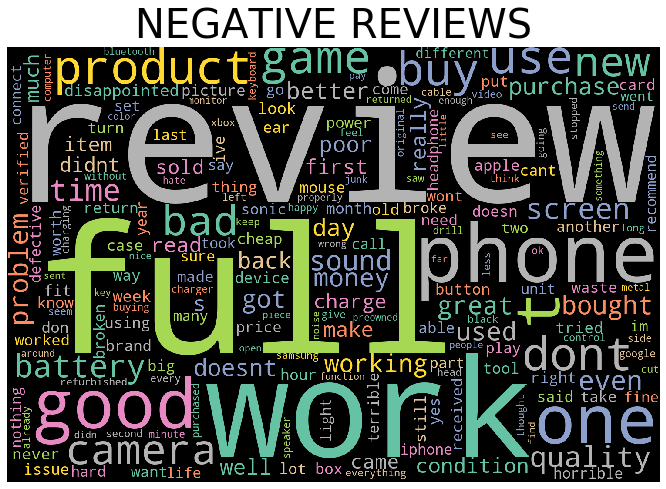

In [45]:
negative = data_preprocessed[data_preprocessed['rating'] == -1]['review']
negative_text = (" ").join(negative.tolist())
wordcloud = WordCloud(width = 1500, height = 1000, collocations=False, colormap='Set2').generate(negative_text)
plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('NEGATIVE REVIEWS', fontsize=40)
plt.show()

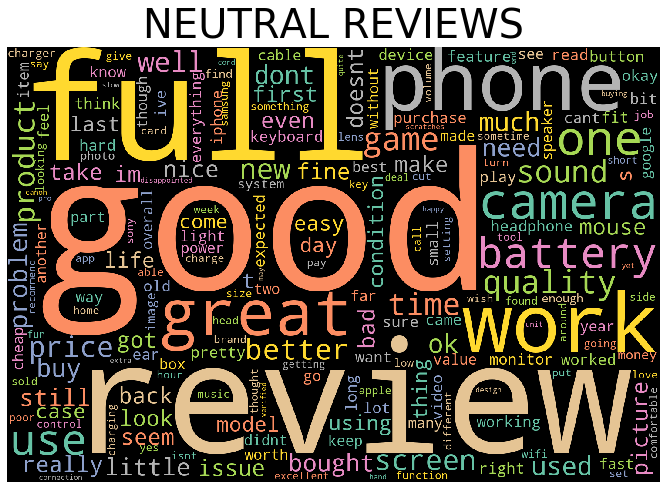

In [46]:
negative = data_preprocessed[data_preprocessed['rating'] == 0]['review']
negative_text = (" ").join(negative.tolist())
wordcloud = WordCloud(width = 1500, height = 1000, collocations=False, colormap='Set2').generate(negative_text)
plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title('NEUTRAL REVIEWS', fontsize=40)
plt.show()

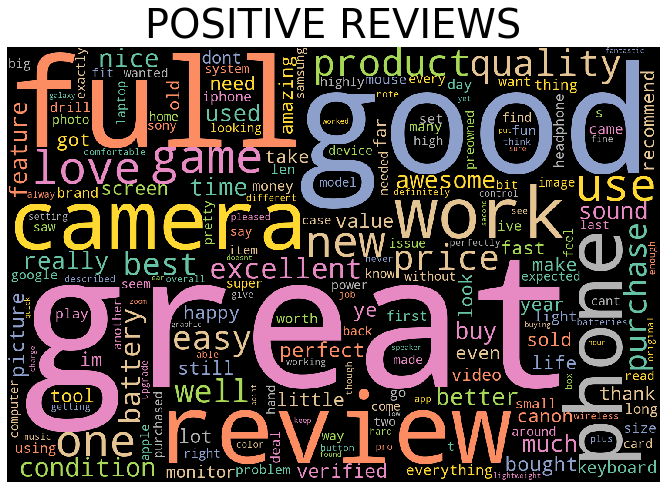

In [47]:
positive = data_preprocessed[data_preprocessed['rating'] == 1]['review']
posivite_text = (" ").join(positive.tolist())
wordcloud = WordCloud(width = 1500, height = 1000, collocations=False, colormap='Set2').generate(posivite_text)
plt.figure(figsize = (12, 8)) 
plt.imshow(wordcloud) 
plt.title('POSITIVE REVIEWS', fontsize=40)
plt.axis("off") 
plt.show()

In [48]:
data_preprocessed.rating.value_counts()

 1    42282
-1     2025
 0     1442
Name: rating, dtype: int64

__TfidfVectorizer parameters__

TfidfVectorizer will be used in classic machine learning approach. Some different values of parameters were tested to selec the most reasonable.

__Default matrix size__

In [51]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(data_preprocessed['review']).todense().shape

(45749, 50753)

__Different parameters values were tested, the most reasonable result is shown below__

In [52]:
#min_df -  When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
#max_df = When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold

tfidf = TfidfVectorizer(min_df=50)
tfidf.fit_transform(data_preprocessed['review']).todense().shape

(45749, 2095)

__Transforming data for modelling__

1. Classic machine learning approach - these have been already preprocessed

In [37]:
data_preprocessed.to_csv('Data_ML.csv', index=True)

2. Neural Networks

In this case data cleaning slightly differs - punctuation is kept

In [39]:
cols = ['review title', 'review content', 'rating']
    
preprocessor_NN = Pipeline([
    ('DuplicateRemover', DuplicatesRemover()),
    ('TextCleaning', TextCleaning(pattern="[\"#\*\+/<=>@[\\]^_`{|}~]")),
    ('ForeignReviewsRemover',ForeignReviewsRemover()),
    ('Connector', Connector()),
    ('Rating', Rating(scale={1:0, 2:0, 3:3, 4:1, 5:1}))
])

preprocessor_NN.fit(data[cols])
data_preprocessed_NN = preprocessor_NN.transform(data[cols])
data_preprocessed_NN.to_csv('Data_NN.csv', index=True)